<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/dropout_MLP_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout in an MLP
Based on sec 4.6 of
http://d2l.ai/chapter_multilayer-perceptrons/dropout.html


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l


# Add dropout layer by hand to an MLP

In [2]:


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

In [3]:
# quick test
torch.manual_seed(0)
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10.,  0., 14.],
        [ 0., 18.,  0.,  0.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [7]:


#  A common trend is to set a lower dropout probability closer to the input layer
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True, dropout1=0.2, dropout2=0.5):
        super(Net, self).__init__()
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, self.dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, self.dropout2)
        out = self.lin3(H2)
        return out


## Fit to FashionMNIST

Uses the [d2l.load_data_fashion_mnist](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py#L200) function.

In [5]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

Fit model using SGD.
Uses the [d2l.train_ch3](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py#L326) function.

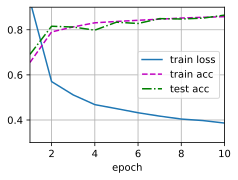

In [9]:
torch.manual_seed(0)
# We pick a wide model to cause overfitting without dropout
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2,
          dropout1=0.5, dropout2=0.5)
loss = nn.CrossEntropyLoss()
lr = 0.5
trainer = torch.optim.SGD(net.parameters(), lr=lr)
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

When we turn dropout off, we notice a slightly larger gap between train and test accuracy.

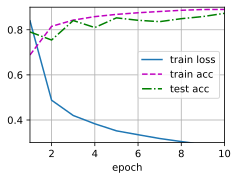

In [10]:
torch.manual_seed(0)
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2,
          dropout1=0.0, dropout2=0.0)
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Dropout using PyTorch layer

In [13]:
dropout1 = 0.5
dropout2 = 0.5
net = nn.Sequential(
    nn.Flatten(), nn.Linear(num_inputs, num_hiddens1), nn.ReLU(),
    # Add a dropout layer after the first fully connected layer
    nn.Dropout(dropout1), nn.Linear(num_hiddens2, num_hiddens1), nn.ReLU(),
    # Add a dropout layer after the second fully connected layer
    nn.Dropout(dropout2), nn.Linear(num_hiddens2, num_outputs))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

torch.manual_seed(0)
net.apply(init_weights);

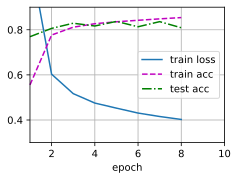

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)